In [1]:
import os
import math

from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.rcParams["figure.figsize"] = (12, 8)

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


2022-02-10 22:34:33.682928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marek/anaconda3/envs/cv/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-10 22:34:33.682945: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (14, 8)


<center> <h2> Problem and dataset description

In [3]:
# TODO: Write a short description of the problem

Link to the dataset can be found [here](https://www.kaggle.com/datamunge/sign-language-mnist).

<center> <h2> Data overview

In [4]:
ROOT_PATH = Path().resolve().parent

DATA_PATH = ROOT_PATH.joinpath("data")
CHECKPOINT_PATH = ROOT_PATH.joinpath("clf_checkpoints")

MNIST_TRAIN = DATA_PATH.joinpath("sign_mnist_train.csv")
MNIST_TEST = DATA_PATH.joinpath("sign_mnist_test.csv")


In [5]:
train_df = pd.read_csv(MNIST_TRAIN)
test_df = pd.read_csv(MNIST_TEST)


In [6]:
print(f"Number of train examples : {train_df.shape[0]}")
print(f"Number of test examples  : {test_df.shape[0]}")

Number of train examples : 27455
Number of test examples  : 7172


In [7]:
test = pd.read_csv(MNIST_TEST)
y = test["label"]


In [8]:
train_df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


<center> <h2> Preprocessing

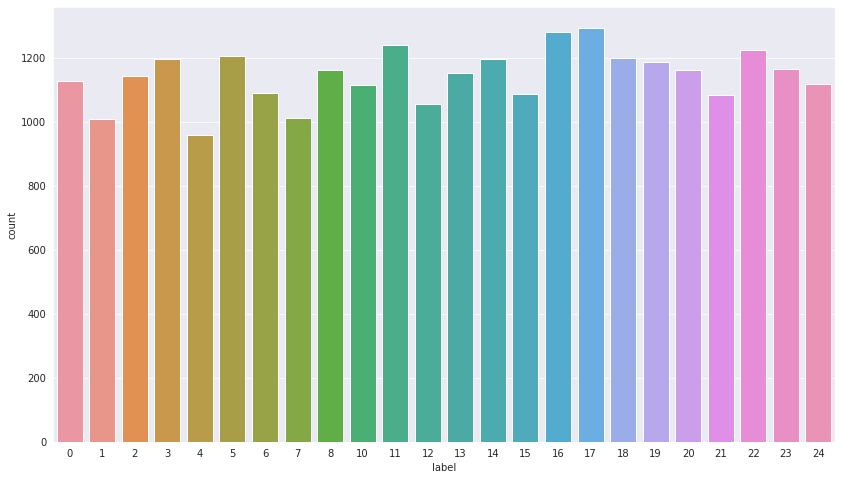

In [9]:
_ = sns.countplot(x=train_df["label"])


In [10]:
y_train, X_train_df = train_df["label"], train_df.drop("label", axis=1)
y_test, X_test_df = test_df["label"], test_df.drop("label", axis=1)


In [11]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)


In [12]:
x_train = X_train_df.values
x_test = X_test_df.values


In [13]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255


In [14]:
# Reshaping the to an image with single chanel
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


<center> <h3> Preview of first the images

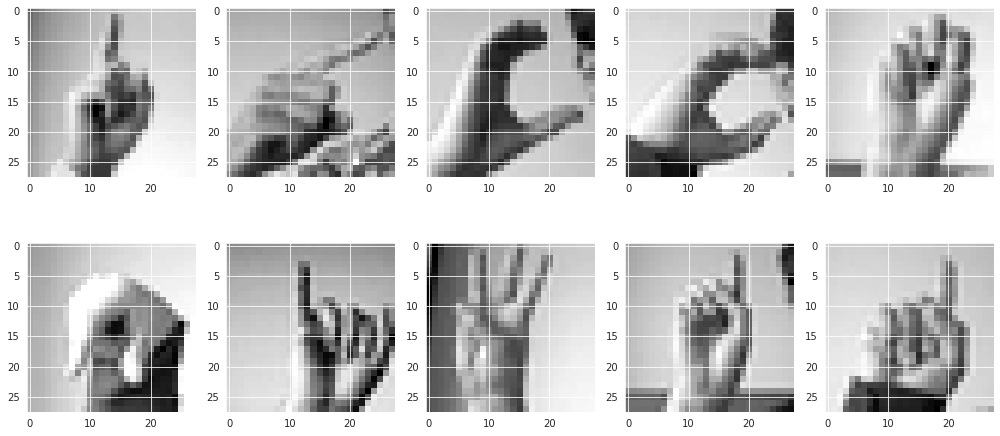

In [15]:
rows, cols = (2, 5)

f, ax = plt.subplots(rows, cols)
for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(x_train[i * cols + j].reshape(28, 28), cmap="gray")
    plt.tight_layout()

plt.show()



<center> <h2> Data Augmentation


In [16]:
# TODO: Verify (Maybe add background to images???); Does it work well??

In [17]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
)  # randomly flip images


datagen.fit(x_train)


For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .

<center> <h2> The Model

In [18]:
# TODO: Verify the model / experiment a bit - to change

In [19]:
model = Sequential()
model.add(
    Conv2D(
        75,
        (3, 3),
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(28, 28, 1),
    )
)
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), padding="same", activation="relu"))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(24, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

2022-02-10 22:34:39.074157: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-10 22:34:39.074182: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: fedora-desktop
2022-02-10 22:34:39.074187: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: fedora-desktop
2022-02-10 22:34:39.074248: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-02-10 22:34:39.074264: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-02-10 22:34:39.074270: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-02-10 22:34:39.074462: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU inst

In [20]:
checkpoint_name = "classificator-{epoch:03d}.ckpt"

batch_size = 64
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.00001
)

# Number of training examples / batch size = number of steps in each epoch
save_freq = math.ceil(train_df.shape[0] / batch_size)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH.joinpath(checkpoint_name),
    verbose=1,
    save_weights_only=True,
    save_freq=5*save_freq, # Save weights every 5 epochs
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.005, patience=5, verbose=1, mode="auto"
)

In [21]:
model.save_weights(CHECKPOINT_PATH.joinpath(checkpoint_name.format(epoch=0)))

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[
        learning_rate_reduction, checkpoint_callback, early_stopping_callback
    ],
)

model.save_weights(CHECKPOINT_PATH.joinpath(checkpoint_name.format(epoch=history.epoch[-1])))


Epoch 1/30
429/429 [==============================] - 22s 49ms/step - loss: 0.9179 - accuracy: 0.7102 - val_loss: 1.1586 - val_accuracy: 0.5745 - lr: 0.0010
Epoch 2/30
429/429 [==============================] - 19s 44ms/step - loss: 0.1725 - accuracy: 0.9425 - val_loss: 0.1685 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 3/30
429/429 [==============================] - 19s 44ms/step - loss: 0.0831 - accuracy: 0.9731 - val_loss: 0.4166 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 4/30
429/429 [==============================] - 20s 46ms/step - loss: 0.0601 - accuracy: 0.9805 - val_loss: 0.4171 - val_accuracy: 0.8539 - lr: 0.0010
Epoch 5/30
427/429 [============================>.] - ETA: 0s - loss: 0.0467 - accuracy: 0.9852
Epoch 5: saving model to /home/marek/Projects/Python/MNIST-sign-language/checkpoints/classificator-005.ckpt
429/429 [==============================] - 19s 45ms/step - loss: 0.0466 - accuracy: 0.9852 - val_loss: 0.0531 - val_accuracy: 0.9826 - lr: 0.0010
Epoch 6/30
429/429 [==

In [22]:
print("Accuracy of the model: ", model.evaluate(x_test, y_test)[1] * 100, "%")


225/225 [==============================] - 1s 6ms/step - loss: 0.0044 - accuracy: 0.9982
Accuracy of the model:  99.81874227523804 %


<center> <h2> Model Overview

In [23]:
# TODO: Verify plots, mabe add some more?
# TODO: Change hardocded values!

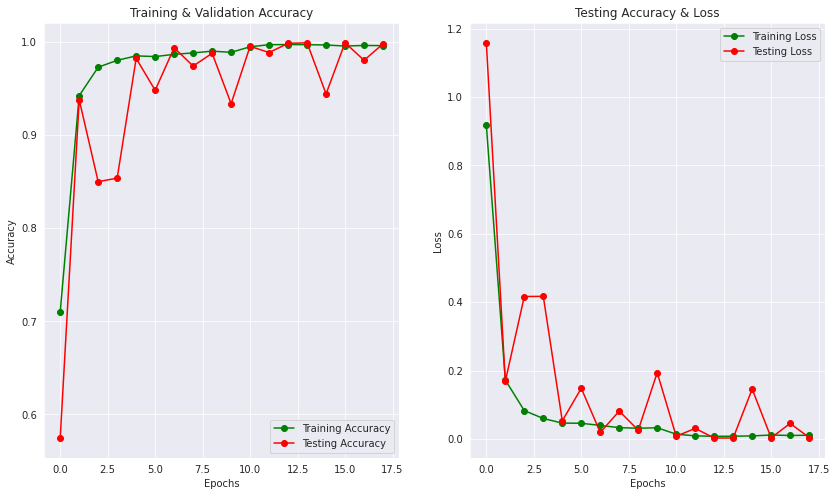

In [24]:
fig, ax = plt.subplots(1, 2)
epochs = history.epoch
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

ax[0].plot(epochs, train_acc, "go-", label="Training Accuracy")
ax[0].plot(epochs, val_acc, "ro-", label="Testing Accuracy")
ax[0].set_title("Training & Validation Accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "g-o", label="Training Loss")
ax[1].plot(epochs, val_loss, "r-o", label="Testing Loss")
ax[1].set_title("Testing Accuracy & Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [25]:
predictions = np.argmax(model.predict(x_test), axis=-1)
for i in range(len(predictions)):
    if predictions[i] >= 9:
        predictions[i] += 1
predictions[:5]


array([ 6,  5, 10,  0, 17])

In [26]:
x_test.shape


(7172, 28, 28, 1)

In [27]:
classes = ["Class " + str(i) for i in range(25) if i != 9]

print(predictions.shape, y.shape)
print(classification_report(y, predictions, target_names=classes))


(7172,) (7172,)
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      0.96      0.98       245
     Class 4       0.99      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      0.98      0.99       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       0.94      1.00      0.97       144
    Class 1

In [28]:
cm = confusion_matrix(y, predictions)


In [29]:
cm = pd.DataFrame(
    cm, index=[i for i in range(25) if i != 9], columns=[i for i in range(25) if i != 9]
)


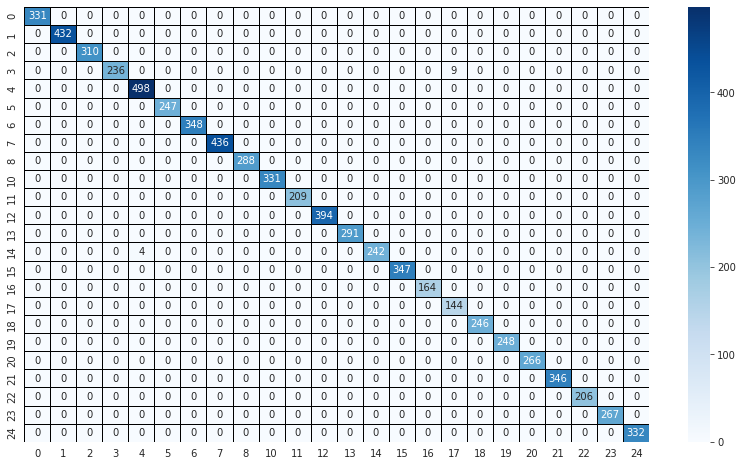

In [30]:
plt.figure()
_ = sns.heatmap(cm, cmap="Blues", linecolor="black", linewidth=1, annot=True, fmt="")

plt.show()

In [31]:
correct = predictions[predictions == y]
correct.shape


(7159,)

**Some of the Correctly Predicted Classes**

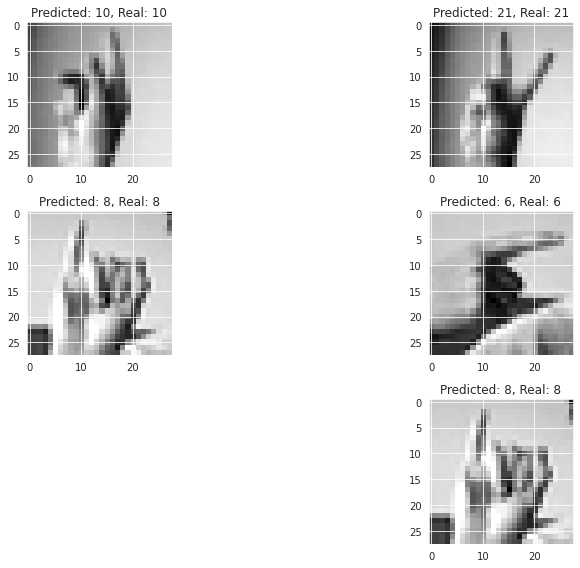

In [32]:
i = 0
plt.figure()
for c in correct[:6]:
    plt.subplot(3, 2, i + 1)
    plt.imshow(x_test[c].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title(f"Predicted: {predictions[c]}, Real: {y[c]}")
    plt.tight_layout()
    i += 1

plt.show()